<a href="https://colab.research.google.com/github/okcza515/TextPokerGame/blob/main/TextPokerGame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from IPython.display import Image, display
from itertools import combinations
import os
import random

class PokerGame:
    CARD_IMAGES_PATH = "/content/drive/MyDrive/TextPokerGame/Card_PNG"

    def __init__(self, players):
        self.players = players
        self.deck = self.generate_deck()
        self.community_cards = []
        self.pot = 0
        self.numberFold = 0
        self.number_all_in = 0
        self.last_bet =0;


    def generate_deck(self):
        suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
        ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
        deck = [{'rank': rank, 'suit': suit} for suit in suits for rank in ranks]
        random.shuffle(deck)
        return deck

    def load_card_image(self, card, size=(50, 75)):
        rank = card['rank']
        suit = card['suit'][0]  # Get the first letter of the suit

        # Example: Construct the file name for the image (e.g., '10C.png', 'AH.png')
        image_name = f"{rank.upper()}{suit.upper()}.png"
        image_path = os.path.join(self.CARD_IMAGES_PATH, image_name)

        # Display the resized image in Colab
        try:
            display(Image(filename=image_path, width=size[0], height=size[1]))
        except FileNotFoundError:
            print(f"Image not found for {rank} of {card['suit']}")

    def deal_community_card(self):
        community_card = self.deck.pop()
        self.community_cards.append(community_card)

    def deal_cards(self):
        for player in self.players:
            player.hand = [self.deck.pop(), self.deck.pop()]

    def display_hand(self, player):
        print(f"\n{player.name}'s hand:")
        for card in player.hand:
            self.load_card_image(card)

    def display_community_cards(self):
        print("\nCommunity Cards:")
        for card in self.community_cards:
            self.load_card_image(card)

    def get_user_bet(self, player):
        while True:
            try:
                bet = int(input(f"{player.name}, enter your bet: [need to bet more than {self.last_bet} or all in ({player.chips})]\n"))
                if (bet >= self.last_bet and bet <= player.chips) or (bet == player.chips):
                    if(bet  == player.chips):
                      print(player.name," HAS ALL IN!")
                      player.has_all_in = 1
                    self.last_bet = bet
                    return bet
                else:
                    print("Invalid bet. Please enter a valid amount.\n")
            except ValueError:
                print("Invalid input. Please enter a number.\n")

    def player_turn(self, player):
        print(f"\n{player.name}'s turn:")
        self.display_hand(player)

        # For simplicity, let's assume players can only bet or fold.

        if player.hasFold == 1:
          return 2
        else:
          while True:
            action = input("Do you want to (B)et or (F)old? \n").upper()
            if action == 'B':
              bet = self.get_user_bet(player)
              player.chips -= bet
              self.pot += bet
              return 1
            elif action == 'F':
              # Player folds, implement fold logic if needed
              player.hasFold = 1
              self.numberFold +=1
              return 0
            else:
              print("Invalid action. Please enter 'B' to bet or 'F' to fold.\n")

    def evaluate_winner(self):
        each_player_all_cards_list = [(player, player.hand + self.community_cards) for player in self.players if not player.hasFold == 1]

        # Evaluate each player's hand
        player_strengths = [(player, self.evaluate_player_strength(cards)) for player, cards in each_player_all_cards_list]
        #print(player_strengths, "1")

        # Find the player with the strongest hand
        winner = self.compare_player_stenght(player_strengths)

        #print(winner,"asdasdasd")
        if type(winner[0]) == type([]):
          print(f"\nShared Winner: ", end = '')
          print([p.name for p in winner[0]])
          print("with ", winner[1])
          for p in winner[0]:
            #split reward
            p.chips += self.pot/len(winner[0])
          print("and each one get pot =", self.pot/len(winner[0]))
        else:
          print(f"\nWinner: {winner[0].name}")
          print("with ", winner[1])
          winner[0].chips += self.pot
          print("and get pot =", self.pot)

    def play_round(self):
        self.deal_cards()
        for i in range(5):  # Deal 5 community cards
            print("\n=======================================\n Round: ", i+1)
            all_fold = False
            for player in self.players:
                if self.number_all_in == len(players) - 1 or self.number_all_in == len(players):
                  #if all/ all except one have alled-in, no need to play any player turn, but still have to deal community card at the next round until reach 5 rounds
                  break
                if player.has_all_in == 1:
                  #if the current player has alled-in already, skip his turn, let the other players play!
                  pass
                else:
                  if player.hasFold == 0:
                    if isinstance(player, AIPlayer):
                      # AI player's turn
                      decision, bet_amount = player.make_decision(self.last_bet, self.community_cards,self)
                      if decision == "Bet":
                        self.last_bet = bet_amount
                        self.pot += bet_amount
                        player.chips -= bet_amount
                      elif decision == "Fold":
                        player.hasFold = 1
                        self.numberFold += 1
                    else:
                      # Human player's turn
                      self.player_turn(player)
                  else:
                    #this player has fold, skip his turn
                    pass
                  if self.numberFold == len(players) - 1:
                    #after a player turn, if he is the last one who folds and leave another remaining one, go showndown and let that remaining guy win
                    all_fold = True
                    break
            if all_fold:
              #if all except one have folded, no need to deal community cards and go to shown down
              break
            else:
              self.deal_community_card()
              self.display_community_cards()

        # Show all cards
        print("\n=======================================\nShowdown:")
        self.display_community_cards()
        for player in self.players:
            self.display_hand(player)

        self.evaluate_winner()

    def suit(self,card):
      return card['suit']

    def rank(self,card):
        #print(self)
        #print("E")
        #print("asdasdsad ", card['rank'],card,type(card['rank']), type(card))
        if card['rank'] == 'A':
          return 14
        elif card['rank'] == 'J':
          return 11
        elif card['rank'] == 'Q':
          return 12
        elif card['rank'] == 'K':
          return 13
        else: return int(card['rank'])

    def find_highest_card(self, player_all_cards):
      cards = sorted(player_all_cards, key = self.rank)
      return cards[-1]

    def pair_count(self, player_all_cards):
      all_combinations = list(combinations(player_all_cards,len(player_all_cards) if len(player_all_cards)<5 else 5))
      number_of_pair = 0
      for cards in all_combinations:
        pair_combination = list(combinations(cards,2))
        #print(pair_combination)
        count_pair = 0
        for pair in pair_combination:
          if(self.rank(pair[0]) == self.rank(pair[1]) ):
              count_pair +=1
        if number_of_pair<count_pair:
          number_of_pair = count_pair
      return number_of_pair

    def is_one_pair(self, player_all_cards):
      return True if self.pair_count(player_all_cards) == 1 else False

    def is_two_pair(self, player_all_cards):
      return True if self.pair_count(player_all_cards) == 2 else False

    def is_three_of_kind(self, player_all_cards):
      if len(player_all_cards)< 3: return False
      return True if self.pair_count(player_all_cards) == 3 else False ##Let's say 3 cards of best 5 is same rank, picking pair would be C3_2 =3

    def is_straight(self, player_all_cards):
      if len(player_all_cards)< 5: return False
      all_combinations = list(combinations(player_all_cards, 5))
      for cards in all_combinations:
        sorted_cards = sorted(cards, key = self.rank)

        ##if the last card is ace but the first is 2, that only be possible for straight is A 2 3 4 5, so in this case the ace is the lowest
        if self.rank(cards[-1]) == 14 and self.rank(cards[0]) == 2:
          sorted_cards = [sorted_cards[-1]] + sorted_cards[:-1]
          first_card_value = 1
        else: first_card_value = self.rank(sorted_cards[0])

        if(first_card_value == self.rank(sorted_cards[1])-1 == self.rank(sorted_cards[2])-2 == self.rank(sorted_cards[3])-3 == self.rank(sorted_cards[4])-4):
            return True

    def is_flush(self,player_all_cards):
      if len(player_all_cards)< 5: return False
      all_combinations = list(combinations(player_all_cards,len(player_all_cards) if len(player_all_cards)<5 else 5))
      for cards in all_combinations:
         if all([self.suit(card)== self.suit(cards[0]) for card in cards[1:]]):
            return True
      return False

    def is_full_house(self,player_all_cards):
      if len(player_all_cards)< 5: return False
      ##Let's say 3 cards of best 5 is same rank, picking pair would be C3_2 =3
      ##and the other 2 cards of best 5 is same other rank, picking pair woud be C2_2 = 1
      ##so they would be 3+1 = 4 possible pair as full house
      return True if self.pair_count(player_all_cards) == 4 else False

    def is_four_of_kind(self, player_all_cards):
      if len(player_all_cards)< 4: return False
      return True if self.pair_count(player_all_cards) == 6 else False ##Let's say 4 cards of best 5 is same rank, picking pair would be C4_2 =6

    def is_straight_flush(self, player_all_cards):
      if len(player_all_cards)< 5: return False
      all_combinations = list(combinations(player_all_cards, 5))
      for cards in all_combinations:
        if(self.is_straight(cards) and self.is_flush(cards)):
            return True
      return False

    def is_royal_flush(self, player_all_cards):
      if self.is_straight_flush(player_all_cards):
        all_combinations = list(combinations(player_all_cards,len(player_all_cards) if len(player_all_cards)<5 else 5))
        for cards in all_combinations:
          sorted_cards = sorted(cards, key = self.rank)
          if self.is_straight_flush(cards) == 10 and \
          (self.rank(sorted_cards[0]) == 10 and self.rank(sorted_cards[1])==11 and  self.rank(sorted_cards[1])==12 and  self.rank(sorted_cards[1])==13 and  self.rank(sorted_cards[1])==14):
             return True
      return False

    def evaluate_player_strength(self, player_all_cards):
      if self.is_royal_flush(player_all_cards):
        return 23
      elif self.is_straight_flush(player_all_cards):
        return 22
      elif self.is_four_of_kind(player_all_cards):
        return 21
      elif self.is_full_house(player_all_cards):
        return 20
      elif self.is_flush(player_all_cards):
        return 19
      elif self.is_straight(player_all_cards):
        return 18
      elif self.is_three_of_kind(player_all_cards):
        return 17
      elif self.is_two_pair(player_all_cards):
        return 16
      elif self.is_one_pair(player_all_cards):
        return 15
      else : return self.rank(self.find_highest_card(player_all_cards))

    def compare_player_stenght(self, player_strengths):
      #given player_strenghts with is list of tuple that contain (player,strenght)
      #assume that the first player is initially the highest
      #print(player_strengths, "2")
      highest_player_info = player_strengths[0]
      for player_info in player_strengths[1:]:
        #check strenght, which is column1
        if highest_player_info[1] < player_info[1]:
          highest_player_info = player_info
        elif highest_player_info[1] == player_info[1]:
          #print(highest_player_info, player_info,highest_player_info[0], player_info[0], "3")
          highest_player_info = self.check_equal(highest_player_info[0], player_info[0], highest_player_info[1])
      #return tuple
      return highest_player_info

    def check_equal(self, player1, player2, strenght):
      #print(player1,"////",player2,"////",strenght)
      player1_all_card = player1.hand + self.community_cards if isinstance(player1, (Player, AIPlayer)) else []
      player1_all_card_sorted = sorted(player1_all_card, key = self.rank)

      player2_all_card = player2.hand + self.community_cards
      player2_all_card_sorted = sorted(player2_all_card, key = self.rank)

      player_cards_tuples = (player1_all_card_sorted, player2_all_card_sorted)

      if strenght == 23:
        #it's indeed a tie due to royal flush is the highest
        return ([player1,player2],strenght)

      if strenght == 22:
        #straight flush
        #finding which straigh flush is higher
        #find each player which cards are straight
        last_index_list = []
        for player_cards in player_cards_tuples:
          player_end_straight_flush_index = 0
          player_count_streak = 0

          #in the case of same rank, only same 5 or more same suit cards can make a straight flush
          #and because we know it is straight flush already, so we know at least 5 cards are the same suit
          #we can discard the unmatched suit out
          player_cards = self.get_most_common_suit_cards(player_cards)

          #because this is straight flush case(not royal flush), that only be possible for straight is A 2 3 4 5, so in this case the ace is the lowest
          #so we swap the ace from the rightmost(highest card) to the leftmost(lowest card), (it is only ace due to the get_most_common_suit)
          if self.rank(player_cards[-1]) == 14:
            player_cards = player_cards[-1] + player_cards[:-1]

          for i in range(len(player_cards)):
            if i == len(player_cards)-1:
              # if this is the last card, no need to check with the next card
              break
            else:
              if self.rank(player_cards[i]) == 14:
                #if this card is Ace (which should be only i = index 0 due to the above codes preparation)
                #this card's value is 1
                card_value = 1
              else: card_value = self.rank(player_cards[i])


              if card_value == self.rank(player_cards[i+1]) - 1:
                if player_count_streak == 0:
                  pass
                else:
                  player_end_straight_flush_index = i+1
                player_count_streak +=1
              else:
                #if the current card's suit&order does not match the next one's suit&order, mean this cards(and previous ones) is not in the straight
                #reset the count streak,  player_end_straight_flush_index will be set within the next loop as usual
                player_count_streak =0
          last_index_list.append(player_end_straight_flush_index)

        #check the last card of the straight flush, the higher is the winner
        if self.rank(player1_all_card_sorted[last_index_list[0]]) > self.rank(player2_all_card_sorted[last_index_list[1]]):
          return (player1,strenght)
        elif self.rank(player1_all_card_sorted[last_index_list[0]]) < self.rank(player2_all_card_sorted[last_index_list[1]]):
          return (player2,strenght)
        else:
          #tie
          return ([player1,player2],strenght)

      if strenght == 21:
        #four of kind
        #get each four of kind rank
        #due to in this case, both of the player must have 4 card to make four of kind, the rest 3 card can be anything we don't care
        four_of_kind_val_list = []
        for player_cards in player_cards_tuples:
          #because we know it is four of kind already, so we know there must be 4 cards that are the same rank
          #the most common cards will have exactly 4 card (cannot be 5 or more same rank due to it's poker card, so the rest will be discard due to lesser duplicated rank)
          player_cards = self.get_most_common_rank_cards(player_cards)

          #check value of any card of the four of kind rank, in this case we check the first card
          #append to the list
          four_of_kind_val_list.append(self.rank(player_cards[0]))


        #check the last card of the four of kind of each player, the higher is the winner
        if four_of_kind_val_list[0] > four_of_kind_val_list[1]:
          return (player1,strenght)
        elif four_of_kind_val_list[0] < four_of_kind_val_list[1]:
          return (player2,strenght)
        else:
          #tie
          return ([player1,player2],strenght)

      if strenght == 20:
        #full house
        #check triple first, if tie check the pair, else tie
        player_start_triple_index = 0
        player_end_triple_index = 0
        triple_index_list = []

        player_start_pair_index = 0
        player_end_pair_index = 0
        pair_index_list = []

        #consider last 3 same card as triple, in case there are 2 triple, the higher triple will be the latest ones
        #so we counting down the index
        for player_cards in player_cards_tuples:
          player_count_streak = 0
          for i in range(len(player_cards)-1,-1,-1):
            if i == 0:
              # if this is the last(first) card, no need to check with the next(previous) card
              break
            else:
              if self.rank(player_cards[i]) == self.rank(player_cards[i-1]):
                if player_count_streak == 0:
                  player_end_triple_index = i
                else:
                  player_start_triple_index = i-1
                player_count_streak +=1
              else:
                #reset the count streak,  player_end_triple_index will be set within the next loop as usual
                player_count_streak =0
              if player_count_streak == 3:
                #meet the first 3 highest triple of a player, no need to further find triple
                break
          triple_index_list.append((player_start_triple_index, player_end_triple_index))

        if self.rank(player1_all_card_sorted[triple_index_list[0][0]]) > self.rank(player2_all_card_sorted[triple_index_list[1][0]]):
          return (player1, strenght)
        elif self.rank(player1_all_card_sorted[triple_index_list[0][0]]) < self.rank(player2_all_card_sorted[triple_index_list[1][0]]):
          return (player2, strenght)
        else: pass

        #now find the hihgest pair of each player
        cards_without_triple_list = []
        for tuple_index, player_cards in enumerate(player_cards_tuples):
          #after getting indexes of triple, we will not consider those cards as pair so we make new list of card except those triples
          player_cards = player_cards[:triple_index_list[tuple_index][0]]+player_cards[triple_index_list[tuple_index][1]+1:]
          cards_without_triple_list.append(player_cards)
          player_count_streak = 0
          for i in range(len(player_cards)-1,-1,-1):
            if i == 0:
              # if this is the last(first) card, no need to check with the next(previous) card
              break
            else:
              if self.rank(player_cards[i]) == self.rank(player_cards[i-1]):
                if player_count_streak == 0:
                  player_end_pair_index = i
                else:
                  player_start_pair_index = i-1
                player_count_streak +=1
              else:
                #reset the count streak,  player_end_pair_index will be set within the next loop as usual
                player_count_streak =0
              if player_count_streak == 2:
                #meet the first 2 highest pair of a player, no need to further find triple
                break
          pair_index_list.append((player_start_pair_index, player_end_pair_index))

        if self.rank(cards_without_triple_list[0][pair_index_list[0][0]]) > self.rank(cards_without_triple_list[1][pair_index_list[1][0]]):
          return (player1, strenght)
        elif self.rank(cards_without_triple_list[0][pair_index_list[0][0]]) < self.rank(cards_without_triple_list[1][pair_index_list[1][0]]):
          return (player2, strenght)
        else:
          #tie
          return ([player1,player2],strenght)

      if strenght == 19:
        #flush
        player1_cards = player_cards_tuples[0]
        player2_cards = player_cards_tuples[1]

        #in the case of same rank, only same 5 or more same suit cards can make a flush
        #and because we know it is flush already, so we know at least 5 cards are the same suit
        #we can discard the unmatched suit out
        player1_cards = self.get_most_common_suit_cards(player1_cards)
        player2_cards = self.get_most_common_suit_cards(player2_cards)

        for i in range(5):
          if self.rank(player1_cards[-1-i]) > self.rank(player2_cards[-1-i]):
            return (player1, strenght)
          if self.rank(player1_cards[-1-i]) < self.rank(player2_cards[-1-i]):
            return (player2, strenght)
          else:
            #tie
            return ([player1,player2], strenght)

      if strenght == 18:
        #straight
        #finding which straigh is higher
        #find each player which cards are straight
        last_index_list = []
        player_cards_list = []
        for player_cards in player_cards_tuples:
          player_end_straight_index = 0
          player_count_streak = 0

          #if the last card(highest card) is ace, we add exclusive ace as the first-lowest card in case if straight is A 2 3 4 5
          if self.rank(player_cards[-1]) == 14:
            player_cards = player_cards[-1] + player_cards[:]

          #remove duplicated rank cards
          unique_ranks = set()  # To store unique ranks
          filtered_card_list = []  # To store cards with unique ranks
          for card in player_cards:
            rank = card["rank"]
            if rank not in unique_ranks:
               unique_ranks.add(rank)
               filtered_card_list.append(card)
          player_cards = filtered_card_list

          player_cards_list.append(player_cards)

          for i in range(len(player_cards)):
            if i == len(player_cards)-1:
              # if this is the last card, no need to check with the next card
              break
            else:
              if self.rank(player_cards[i]) == 14 and i == 0:
                #if this card is Ace and it is the lower ace we added (index 0)
                #this card's value is 1
                card_value = 1
              else: card_value = self.rank(player_cards[i])


              if card_value == self.rank(player_cards[i+1]) - 1:
                if player_count_streak == 0:
                  pass
                else:
                  player_end_straight_index = i+1
                player_count_streak +=1
              else:
                #if the current card's suit&order does not match the next one's suit&order, mean this cards(and previous ones) is not in the straight
                #reset the count streak,  player_end_straight_index will be set within the next loop as usual
                player_count_streak =0
          last_index_list.append(player_end_straight_index)

        for i in range(5):
          #check the last card of the straight, the higher is the winner, if tie check lesser one
          if self.rank(player_cards_list[0][last_index_list[0]-i]) > self.rank(player_cards_list[1][last_index_list[1]-i]):
            return (player1,strenght)
          elif self.rank(player_cards_list[0][last_index_list[0]-i]) < self.rank(player_cards_list[1][last_index_list[1]-i]):
            return (player2,strenght)
          else:
            #tie, check lesser higest
            pass

        #if after the 5 best cards checking and no return, its a tie
        return ([player1,player2],strenght)

      if strenght == 17:
        #triple
        #in 7 cards, there are only one triple, no other pair or other triple because it will make a full house
        player_start_triple_index = 0
        player_end_triple_index = 0
        triple_index_list = []

        player_start_pair_index = 0
        player_end_pair_index = 0
        pair_index_list = []

        #consider last 3 same card as triple, in case there are 2 triple, the higher triple will be the latest ones
        #so we counting down the index
        for player_cards in player_cards_tuples:
          player_count_streak = 0
          for i in range(len(player_cards)-1,-1,-1):
            if i == 0:
              # if this is the last(first) card, no need to check with the next(previous) card
              break
            else:
              if self.rank(player_cards[i]) == self.rank(player_cards[i-1]):
                if player_count_streak == 0:
                  player_end_triple_index = i
                else:
                  player_start_triple_index = i-1
                player_count_streak +=1
              else:
                #reset the count streak,  player_end_triple_index will be set within the next loop as usual
                player_count_streak =0
              if player_count_streak == 2:
                #meet the first highest triple of a player, no need to further find triple
                break
          triple_index_list.append((player_start_triple_index, player_end_triple_index))

        if self.rank(player1_all_card_sorted[triple_index_list[0][0]]) > self.rank(player2_all_card_sorted[triple_index_list[1][0]]):
          return (player1, strenght)
        elif self.rank(player1_all_card_sorted[triple_index_list[0][0]]) < self.rank(player2_all_card_sorted[triple_index_list[1][0]]):
          return (player2, strenght)
        else: pass

        #if the triple is tie, now check the other 2 higest cards(if exist)
        #but first we will not consider triple anymore so we discard triple we found
        cards_without_triple_list = []
        for tuple_index, player_cards in enumerate(player_cards_tuples):
          #after getting indexes of triple, we will not consider those cards as pair so we make new list of card except those triples
          player_cards = player_cards[:triple_index_list[tuple_index][0]]+player_cards[triple_index_list[tuple_index][1]+1:]
          cards_without_triple_list.append(player_cards)

        #check highest 0,1 or 2 other cards after considering triple, depend on the numeber of each player number of remaining cards
        for i in range(2):
          if 0 == len(cards_without_triple_list[0])-i or 0 == len(cards_without_triple_list[1])-i:
            #if a any player lenght of remaining cards is lesser than 2 (1 or 0 card left), no need to continue the unnessessary loop
            break
          else:
            if self.rank(cards_without_triple_list[0][-1-i]) > self.rank(cards_without_triple_list[1][-1-i]):
              return (player1, strenght)
            elif self.rank(cards_without_triple_list[0][-1-i]) < self.rank(cards_without_triple_list[1][-1-i]):
              return (player2, strenght)
            else:
              #tie
              pass

        #if after checking the 0-2 other highest cards and no return, its a tie
        return ([player1,player2],strenght)

      if strenght == 16:
        #two pair
        #in 7 cards, there are 2 different pair, the rest 3 cards cannot be triple else it'll be full house instead (but still can be pair so we consider 2 highest pair from the lastest cards)
        player_start_pair1_index = 0
        player_end_pair1_index = 0
        pair1_index_list = []

        player_start_pair2_index = 0
        player_end_pair2_index = 0
        pair2_index_list = []

        #consider last 2 same card as pair, in case there are 2 or 3 pairs, the higher pair will be the latest one
        #so we counting down the index
        for player_cards in player_cards_tuples:
          player_count_streak = 0
          for i in range(len(player_cards)-1,-1,-1):
            if i == 0:
              # if this is the last(first) card, no need to check with the next(previous) card
              break
            else:
              if self.rank(player_cards[i]) == self.rank(player_cards[i-1]):
                if player_count_streak == 0:
                  player_start_pair1_index = i-1
                  player_end_pair1_index = i
                else:
                  player_start_pair1_index = i-1
                player_count_streak +=1
              else:
                #reset the count streak,  player_end_pair1_index will be set within the next loop as usual
                player_count_streak =0
              if player_count_streak == 1:
                #meet the first highest pair of a player, no need to further find the pair
                break
          pair1_index_list.append((player_start_pair1_index, player_end_pair1_index))

        #check first pair
        if self.rank(player1_all_card_sorted[pair1_index_list[0][0]]) > self.rank(player2_all_card_sorted[pair1_index_list[1][0]]):
          return (player1, strenght)
        elif self.rank(player1_all_card_sorted[pair1_index_list[0][0]]) < self.rank(player2_all_card_sorted[pair1_index_list[1][0]]):
          return (player2, strenght)
        else:
          #first pair tie, so we consider another pair
          pass

        #now find the second hihgest pair of each player
        cards_without_first_pair_list = []
        for tuple_index, player_cards in enumerate(player_cards_tuples):
          #after getting indexes of the first pair, we will not consider those cards as second pair so we make new list of card except those first pair
          player_cards = player_cards[:pair1_index_list[tuple_index][0]]+player_cards[pair1_index_list[tuple_index][1]+1:]
          cards_without_first_pair_list.append(player_cards)

          player_count_streak = 0
          for i in range(len(player_cards)-1,-1,-1):
            if i == 0:
              # if this is the last(first) card, no need to check with the next(previous) card
              break
            else:
              if self.rank(player_cards[i]) == self.rank(player_cards[i-1]):
                if player_count_streak == 0:
                  player_start_pair2_index = i-1
                  player_end_pair2_index = i
                else:
                  player_start_pair2_index = i-1
                player_count_streak +=1
              else:
                #reset the count streak,  player_end_pair2_index will be set within the next loop as usual
                player_count_streak =0
              if player_count_streak == 1:
                #meet the second highest pair of a player, no need to further find pair
                break
          pair2_index_list.append((player_start_pair2_index, player_end_pair2_index))

        if self.rank(cards_without_first_pair_list[0][pair2_index_list[0][0]]) > self.rank(cards_without_first_pair_list[1][pair2_index_list[1][0]]):
          return (player1, strenght)
        elif self.rank(cards_without_first_pair_list[0][pair2_index_list[0][0]]) < self.rank(cards_without_first_pair_list[1][pair2_index_list[1][0]]):
          return (player2, strenght)
        else:
          #tie
          if len(cards_without_first_pair_list[0]) == 2:
            #there is no card left aside from the second pair, so it's a tie
            return ([player1,player2],strenght)
          else:
            #there still be other cards, we will consider the only one highest cards of each player
            if self.rank(cards_without_first_pair_list[0][-1]) > self.rank(cards_without_first_pair_list[1][-1]):
              return (player1, strenght)
            elif self.rank(cards_without_first_pair_list[0][-1]) < self.rank(cards_without_first_pair_list[1][-1]):
              return (player2, strenght)
            else:
              #tie, no need to continue compare more cards because it is best 5 cards already
              return ([player1,player2],strenght)

      if strenght == 15:
        #one pair
        #in 7 cards, there are only 1 pair, the rest 5 cards cannot be triple or other pair else it'll be full house or two pair instead
        player_start_pair_index = 0
        player_end_pair_index = 0
        pair_index_list = []

        #consider last 2 same card as pair
        #we counting down the index
        for player_cards in player_cards_tuples:
          player_count_streak = 0
          for i in range(len(player_cards)-1,-1,-1):
            if i == 0:
              # if this is the last(first) card, no need to check with the next(previous) card
              break
            else:
              if self.rank(player_cards[i]) == self.rank(player_cards[i-1]):
                if player_count_streak == 0:
                  player_start_pair_index = i-1
                  player_end_pair_index = i
                else:
                  player_start_pair_index = i-1
                player_count_streak +=1
              else:
                #reset the count streak,  player_end_pair_index will be set within the next loop as usual
                player_count_streak =0
              if player_count_streak == 1:
                #meet the first(and only) highest pair of a player, no need to further find the pair
                break
          pair_index_list.append((player_start_pair_index, player_end_pair_index))

        #check first pair
        if self.rank(player1_all_card_sorted[pair_index_list[0][0]]) > self.rank(player2_all_card_sorted[pair_index_list[1][0]]):
          return (player1, strenght)
        elif self.rank(player1_all_card_sorted[pair_index_list[0][0]]) < self.rank(player2_all_card_sorted[pair_index_list[1][0]]):
          return (player2, strenght)
        else:
          #if pair tie, so we consider other cards(if exists)
          pass

        #check the rest best cart
        #but before that, we will not consider those pair cards so we make new list of card except those  pair
        cards_without_pair_list = []
        for tuple_index, player_cards in enumerate(player_cards_tuples):
          player_cards = player_cards[:pair_index_list[tuple_index][0]]+player_cards[pair_index_list[tuple_index][1]+1:]
          cards_without_pair_list.append(player_cards)

        #check highest 0,1,2, or 3 other cards after considering triple, depend on the numeber of each player number of remaining cards
        for i in range(3):
          if 0 == len(cards_without_pair_list[0])-i or 0 == len(cards_without_pair_list[1])-i:
            #if a any player lenght of remaining cards is lesser than 3 (2, 1 or 0 card left), no need to continue the unnessessary loop
            break
          else:
            if self.rank(cards_without_pair_list[0][-1-i]) > self.rank(cards_without_pair_list[1][-1-i]):
              return (player1, strenght)
            elif self.rank(cards_without_pair_list[0][-1-i]) < self.rank(cards_without_pair_list[1][-1-i]):
              return (player2, strenght)
            else:
              #tie
              pass

        #if after checking the 0-3 other highest cards and no return, its a tie
        return ([player1,player2],strenght)

      if strenght <= 14:
        #highest card
        #if highest is tie, check best lesser highest ones
         for i in range(4):
          if 0 == len(player1_all_card_sorted)-i or 0 == len(player2_all_card_sorted)-i:
            #if a any player lenght of remaining cards is lesser than 4 cards, no need to continue the unnessessary loop
            break
          else:
            if self.rank(player1_all_card_sorted[-1-i]) > self.rank(player2_all_card_sorted[-1-i]):
              return (player1, strenght)
            elif self.rank(player1_all_card_sorted[-1-i]) < self.rank(player2_all_card_sorted[-1-i]):
              return (player2, strenght)
            else:
              #tie
              return ([player1,player2],strenght)


    def get_most_common_suit_cards(self, cards):
      suit_counts = {}  # Dictionary to store the count of each suit

      # Count the occurrences of each suit
      for card in cards:
        suit = card["suit"]
        suit_counts[suit] = suit_counts.get(suit, 0) + 1

      # Find the most common suit
      most_common_suit = max(suit_counts, key=suit_counts.get)

      # Filter the list to keep only the tuples with the most common suit
      result = [card for card in cards if card["suit"] == most_common_suit]

      return result

    def get_most_common_rank_cards(self, cards):
      rank_counts = {}  # Dictionary to store the count of each rank

      # Count the occurrences of each rank
      for card in cards:
        rank = card["rank"]
        rank_counts[rank] = rank_counts.get(rank, 0) + 1

      # Find the most common rank
      most_common_rank = max(rank_counts, key=rank_counts.get)

      # Filter the list to keep only the tuples with the most common suit
      result = [card for card in cards if card["rank"] == most_common_rank]

      return result


In [4]:
class Player:
    def __init__(self, name, chips=1000):
        self.name = name
        self.hand = []
        self.hasFold = 0
        self.has_all_in = 0
        self.chips = chips

In [22]:
import random

class AIPlayer:
    def __init__(self, name,chips=1000):
        self.name = name
        self.hand = []
        self.has_all_in = 0
        self.hasFold = 0
        self.chips = chips

    def make_decision(self, last_bet, community_cards, current_PokerGame):
        # Combine player's hand with community cards to evaluate the hand strength
        all_cards = self.hand + community_cards

        # Add your hand evaluation logic here
        hand_strength = current_PokerGame.evaluate_player_strength(all_cards)

        # Decision-making logic based on hand strength
        if hand_strength >= random.randint(2,14):  # Adjust the threshold based on your criteria
             Bet = min(self.chips, last_bet + (10*((random.randint(10, max(10, self.chips)) +9)//10)) )  # Bet more than of the current bet or all in if not enough chips
             if Bet == self.chips:
              self.has_all_in = 1
              print(self.name," HAS ALL IN!")
             else:
              print(self.name," has bet", Bet)
             return "Bet", Bet
        else:
            print(self.name," has fold")
            return "Fold", 0  # Fold if the hand strength is below the threshold

NEW GAME

 Round:  1

Player 1's turn:

Player 1's hand:


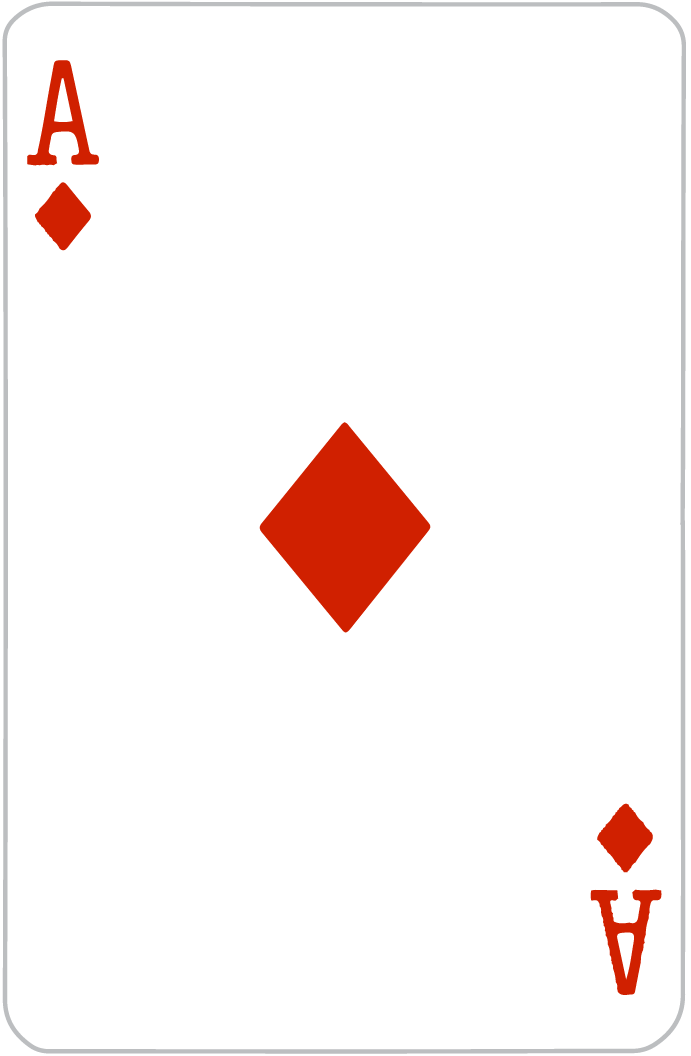

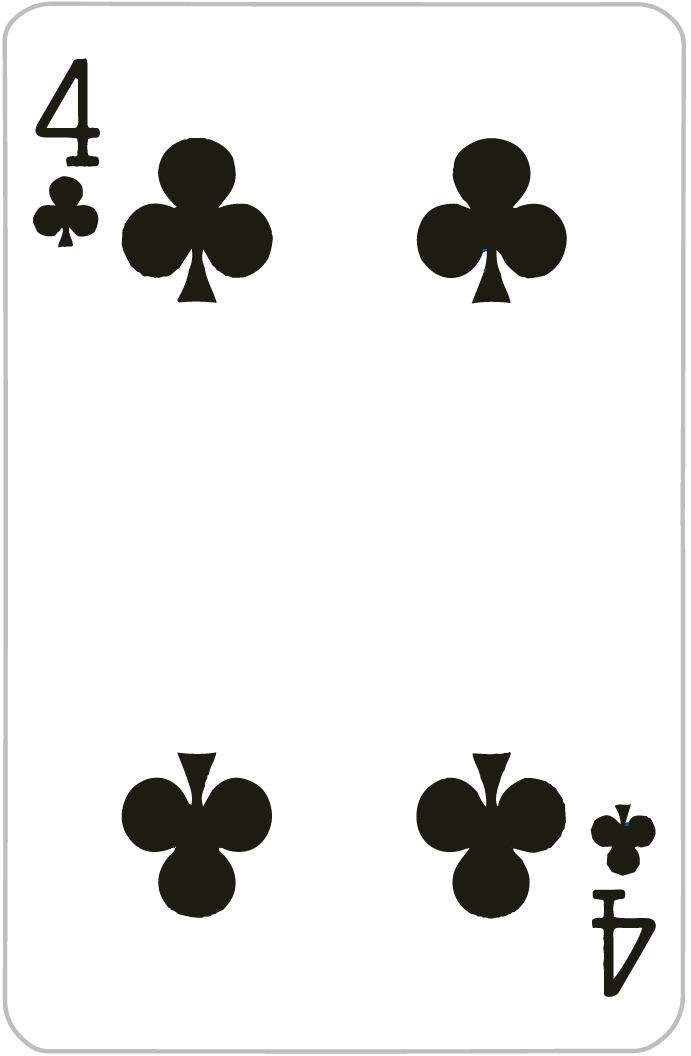

Do you want to (B)et or (F)old? 
B
Player 1, enter your bet: [need to bet more than 0 or all in (1000)]
sfs
Invalid input. Please enter a number.

Player 1, enter your bet: [need to bet more than 0 or all in (1000)]
B
Invalid input. Please enter a number.

Player 1, enter your bet: [need to bet more than 0 or all in (1000)]
100
AI Bot  has bet 920

Community Cards:


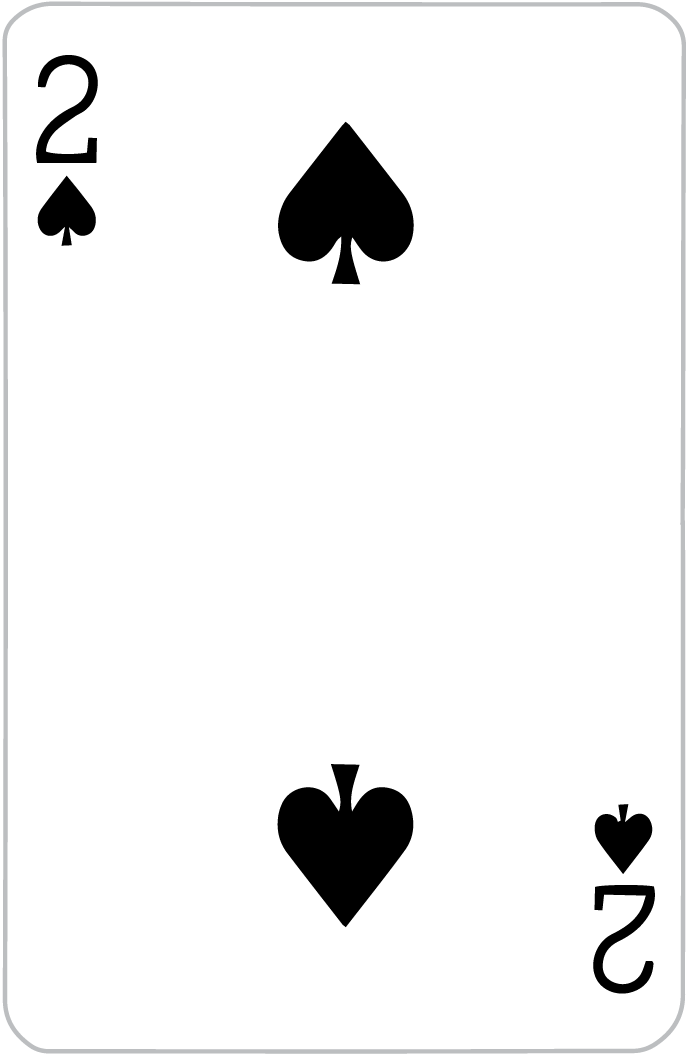


 Round:  2

Player 1's turn:

Player 1's hand:


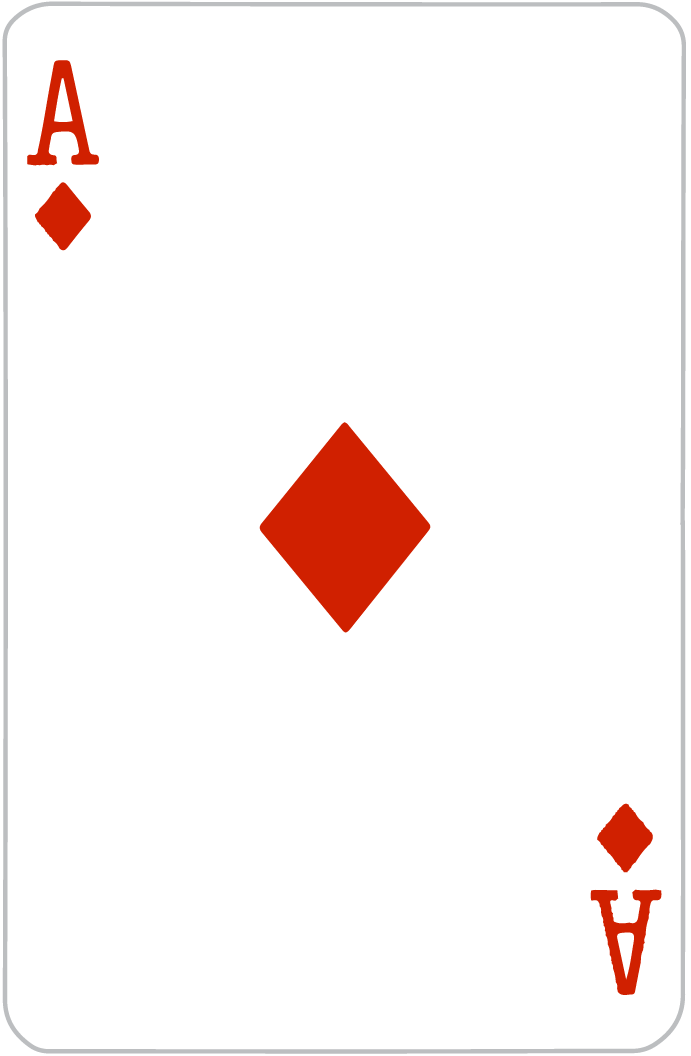

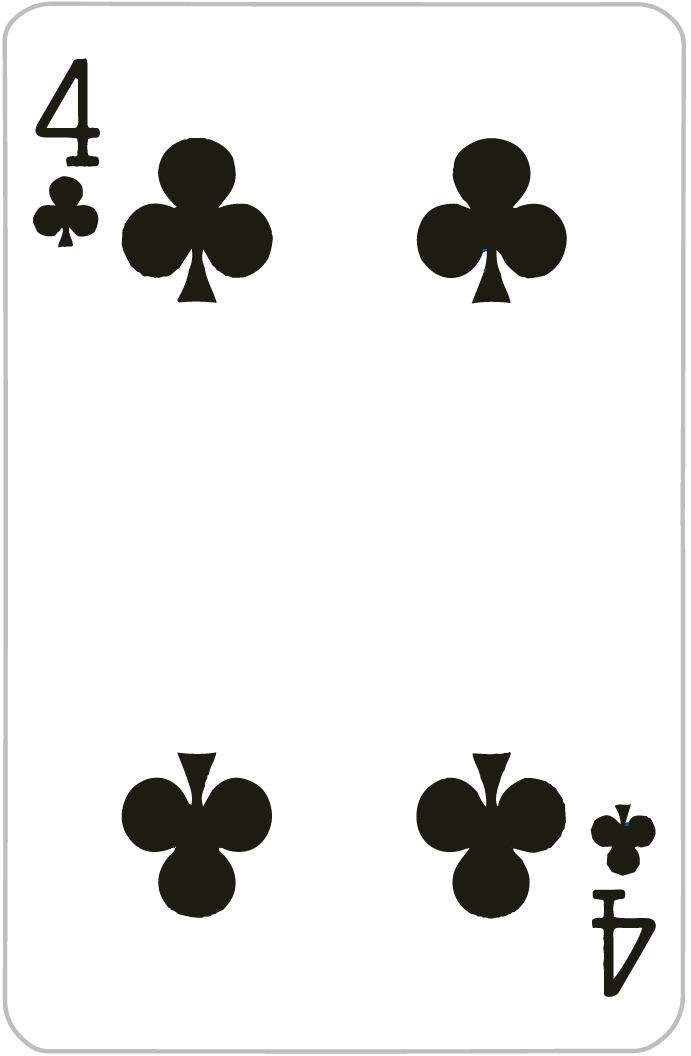

Do you want to (B)et or (F)old? 
B
Player 1, enter your bet: [need to bet more than 920 or all in (900)]
900
Player 1  HAS ALL IN!
AI Bot  HAS ALL IN!

Community Cards:


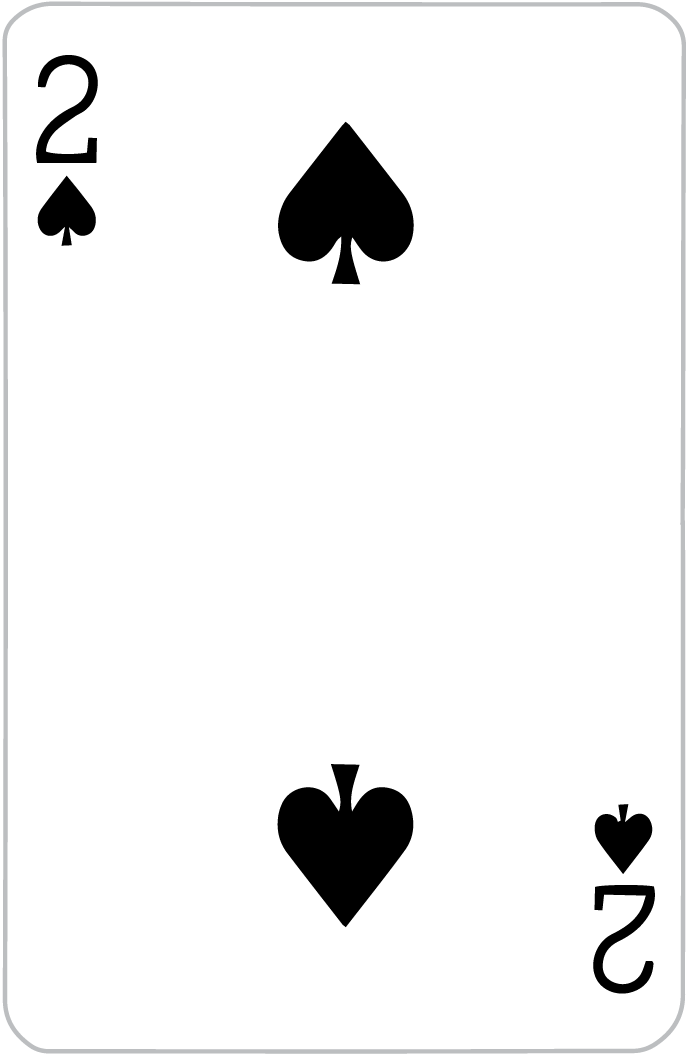

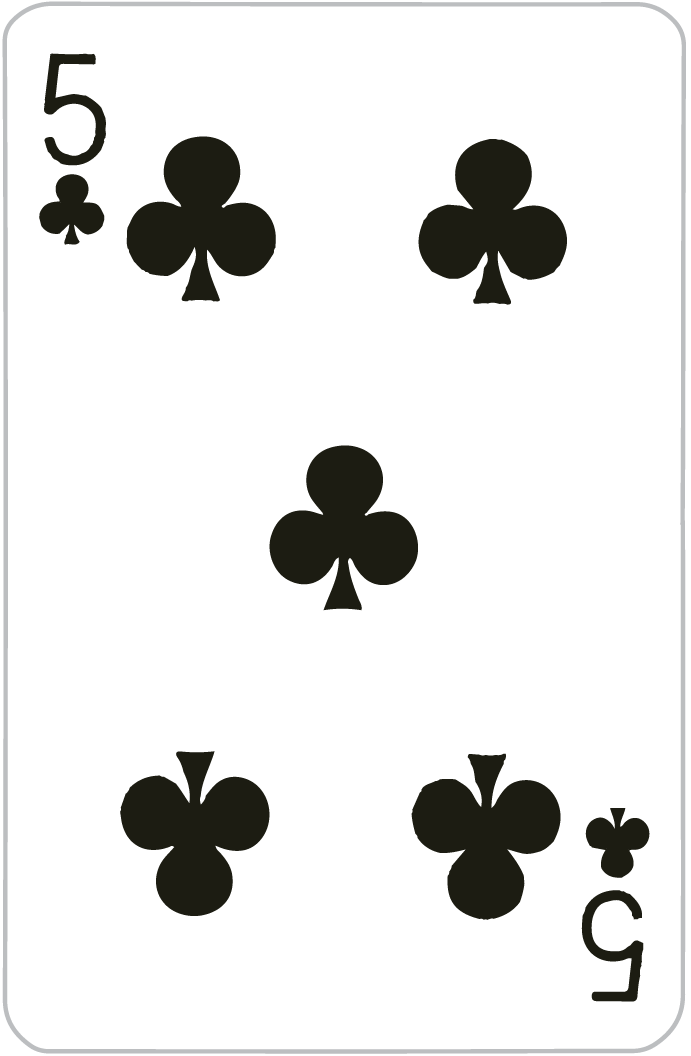


 Round:  3

Community Cards:


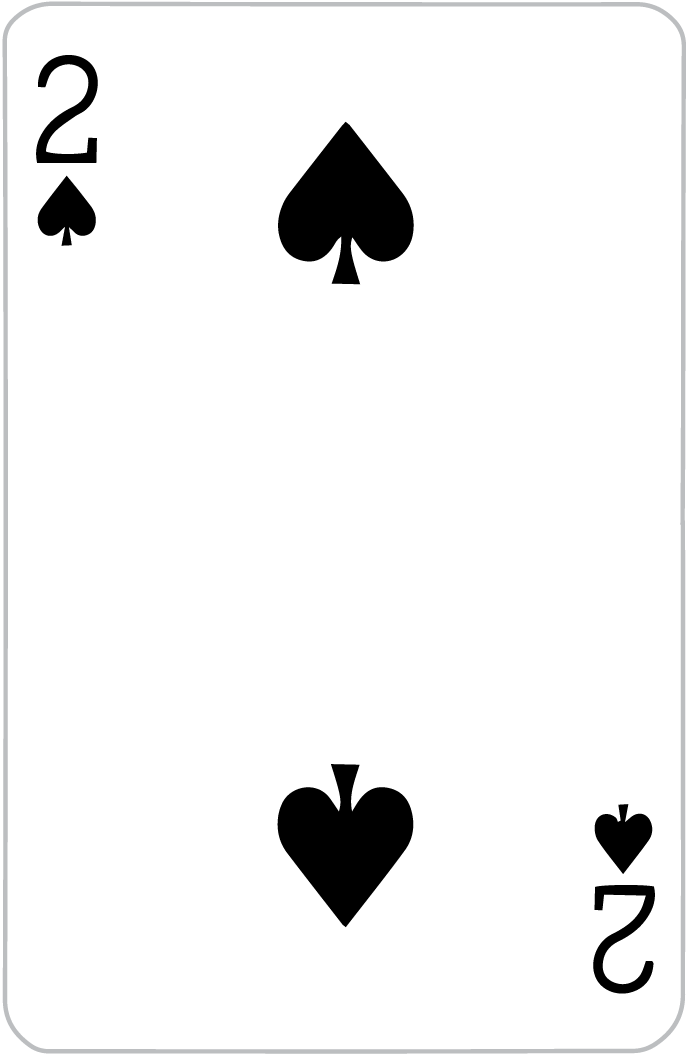

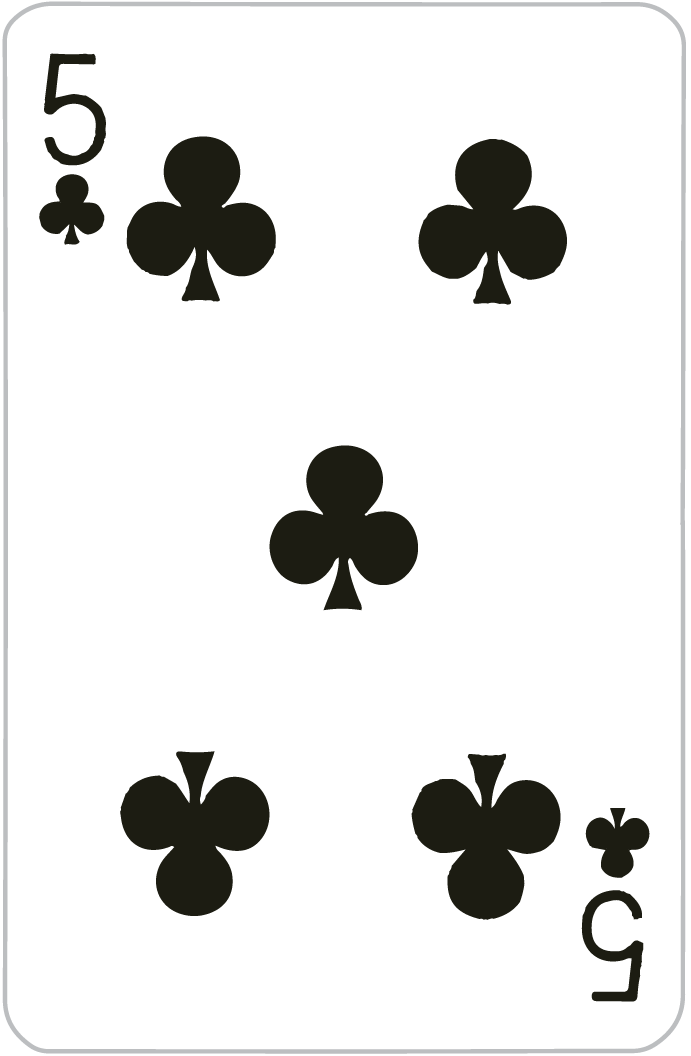

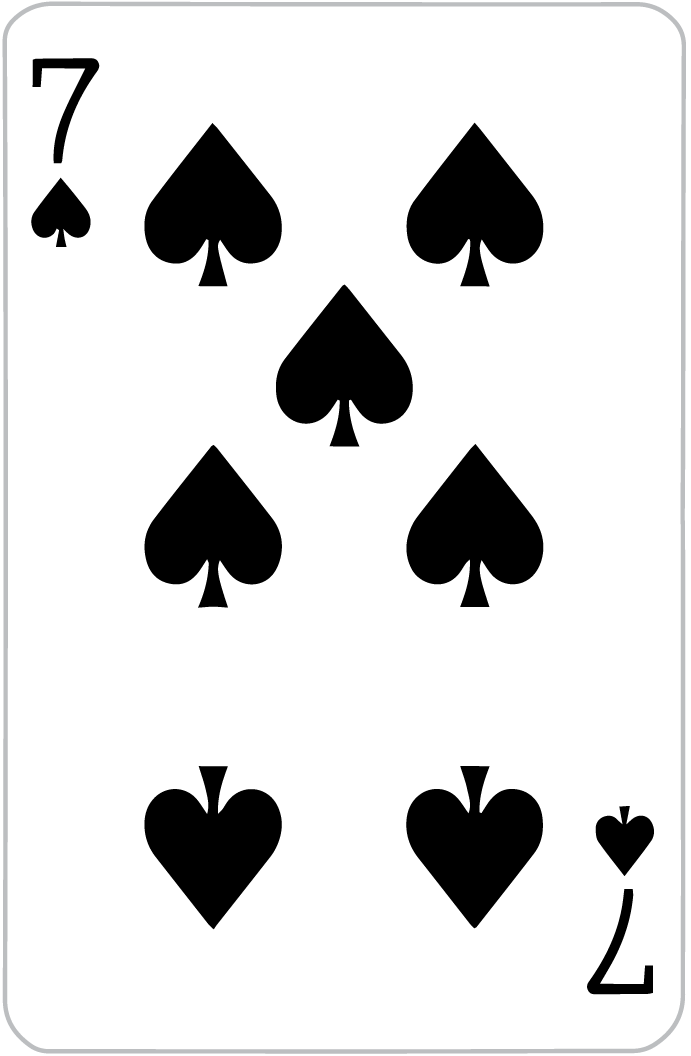


 Round:  4

Community Cards:


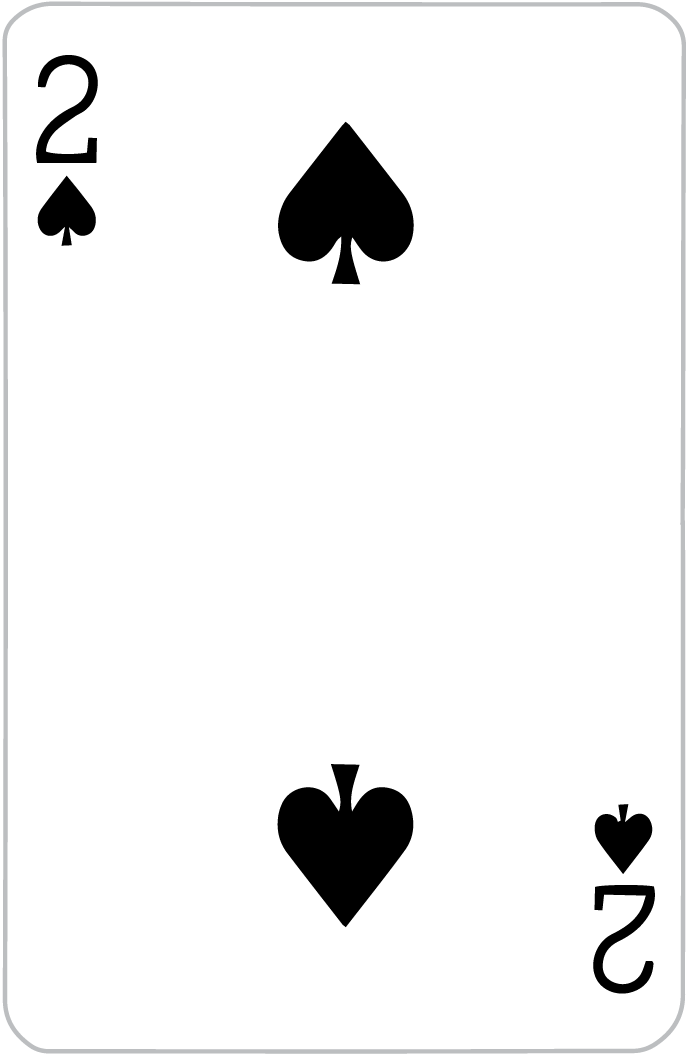

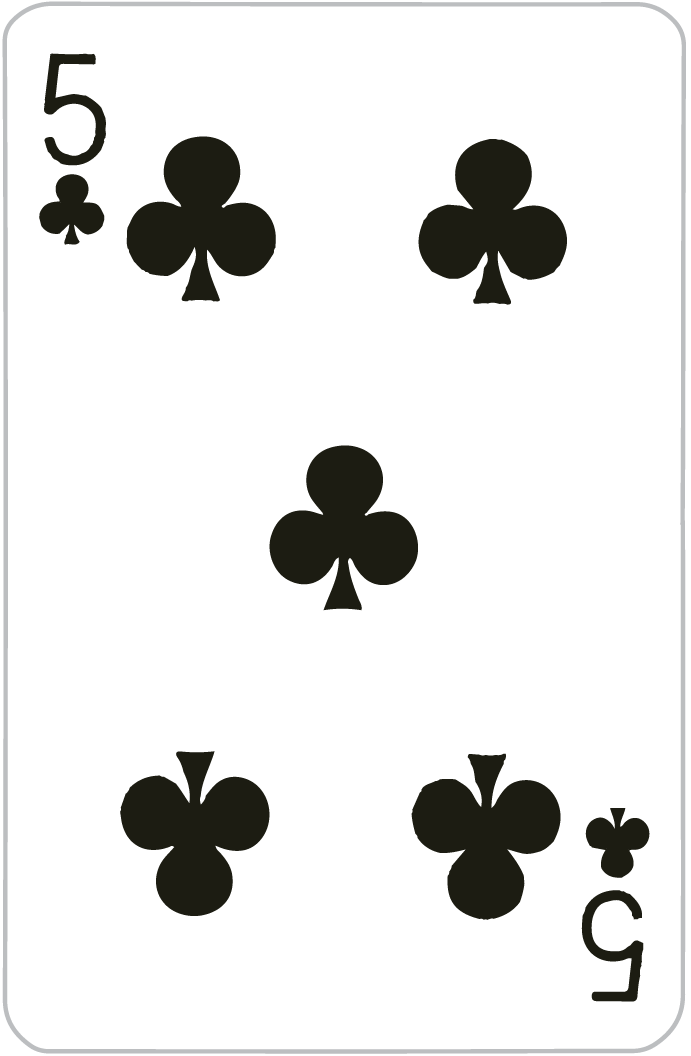

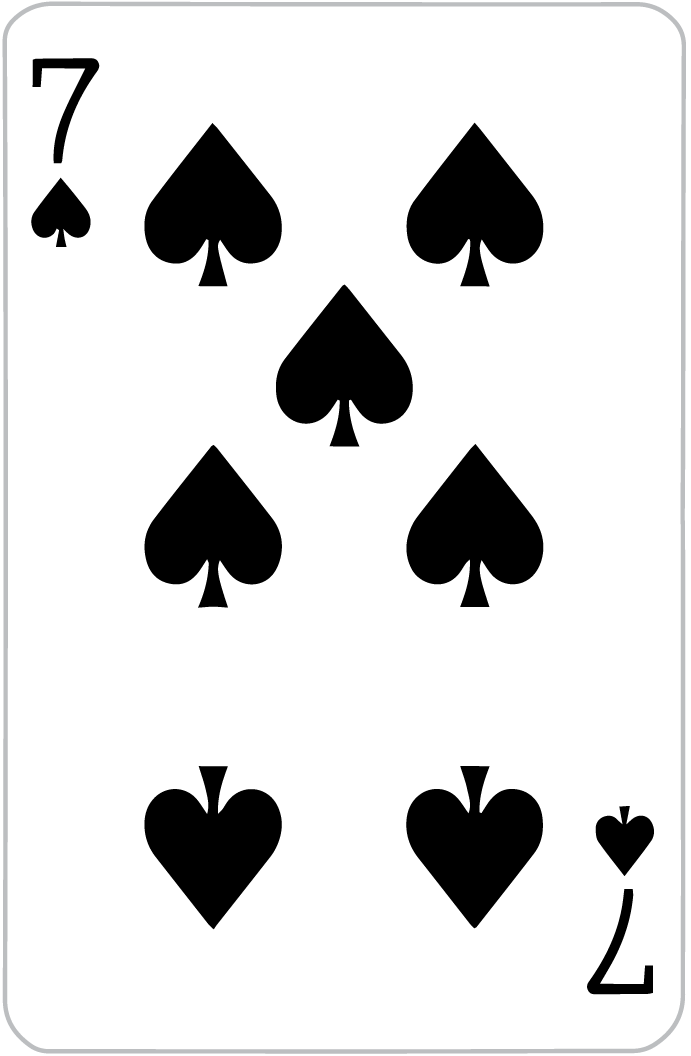

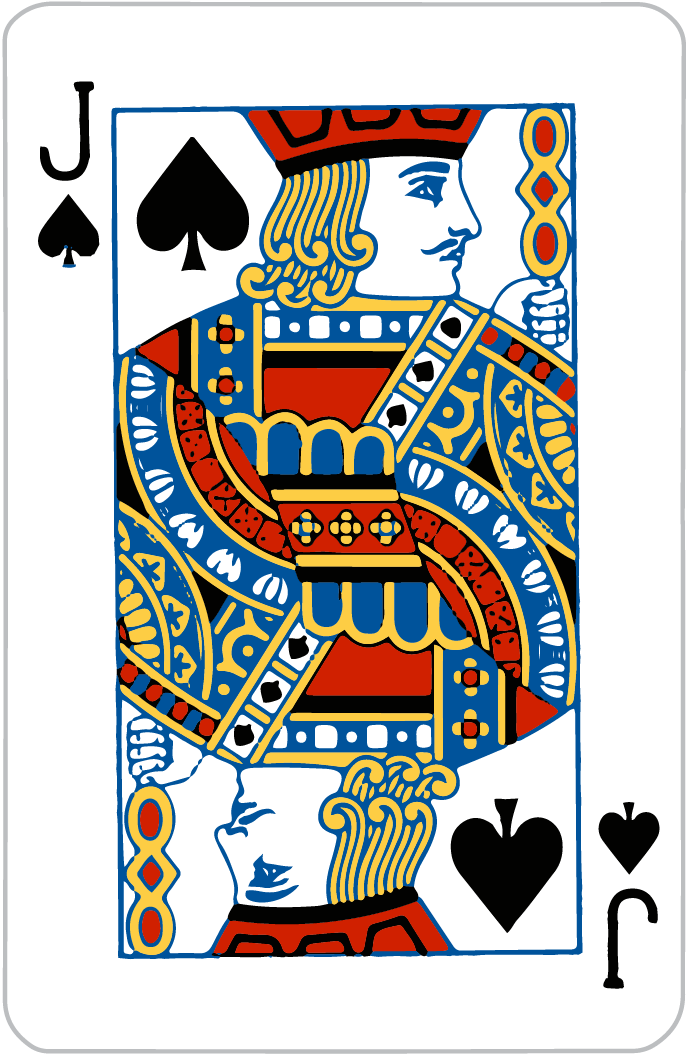


 Round:  5

Community Cards:


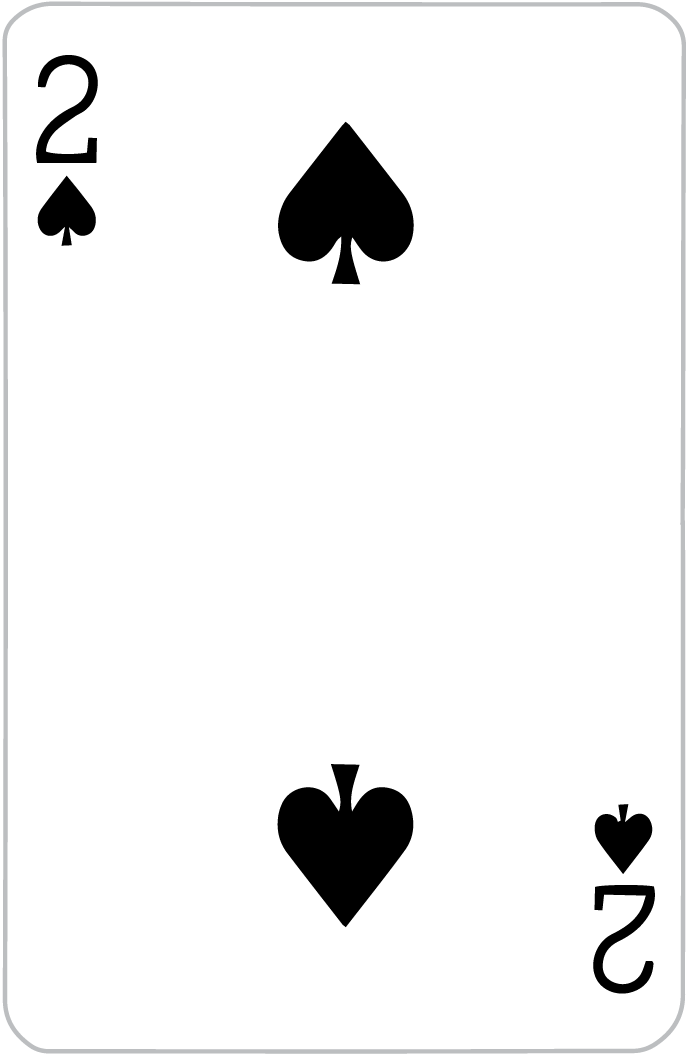

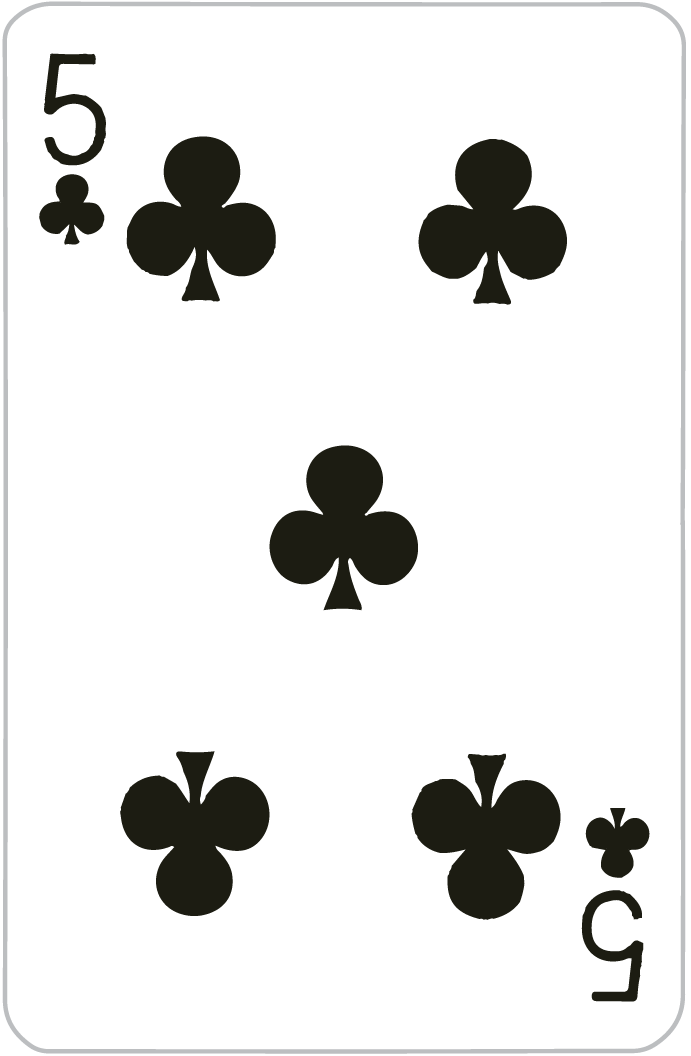

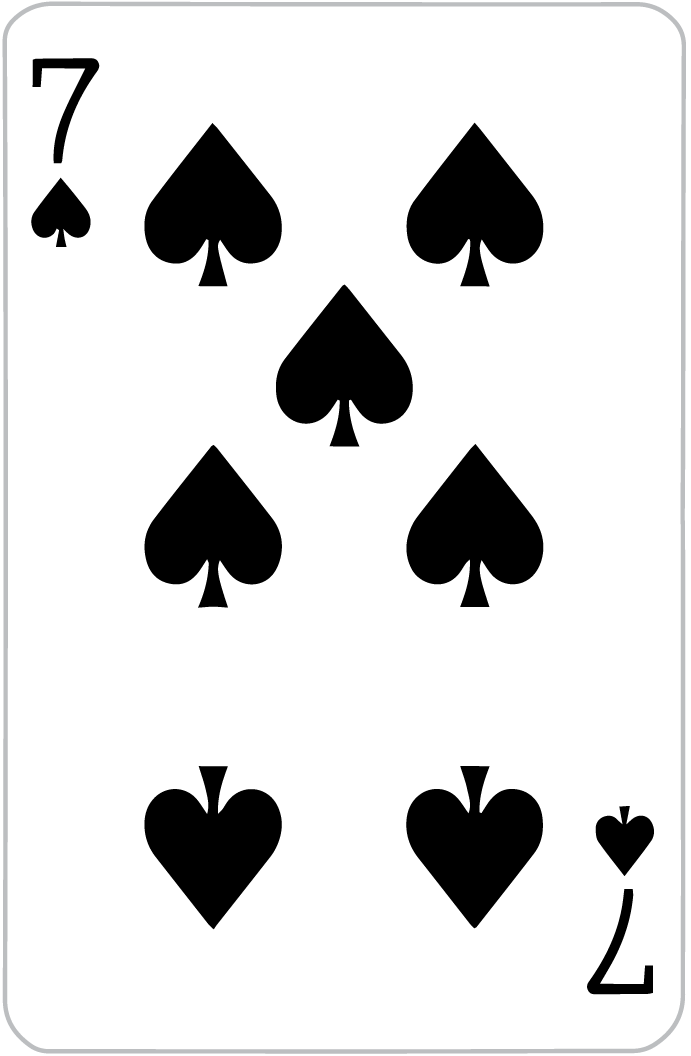

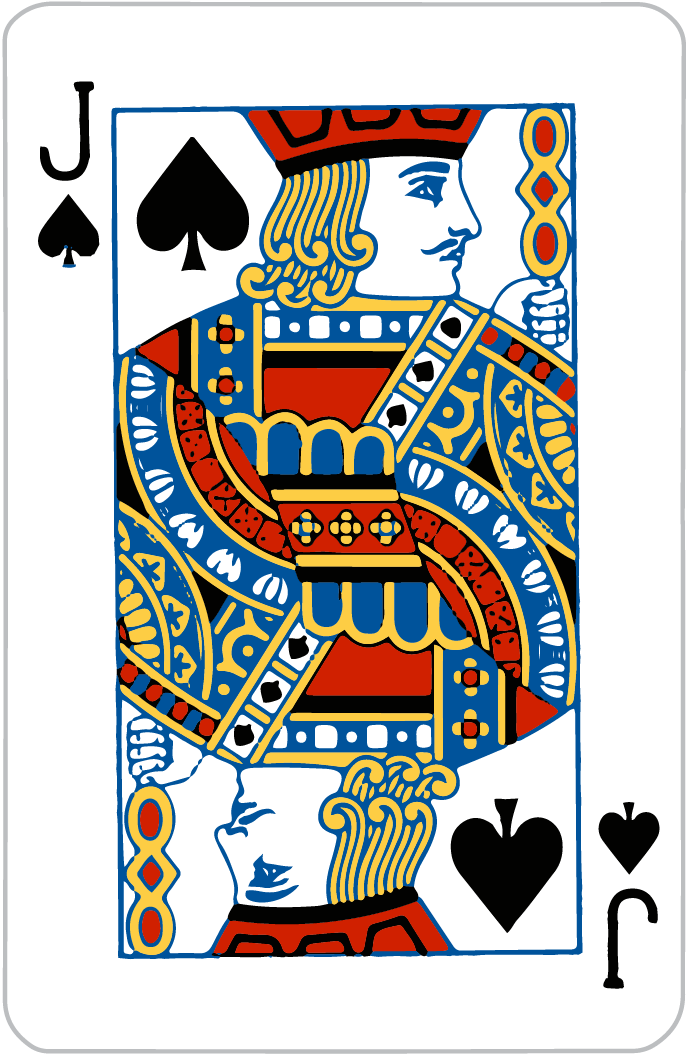

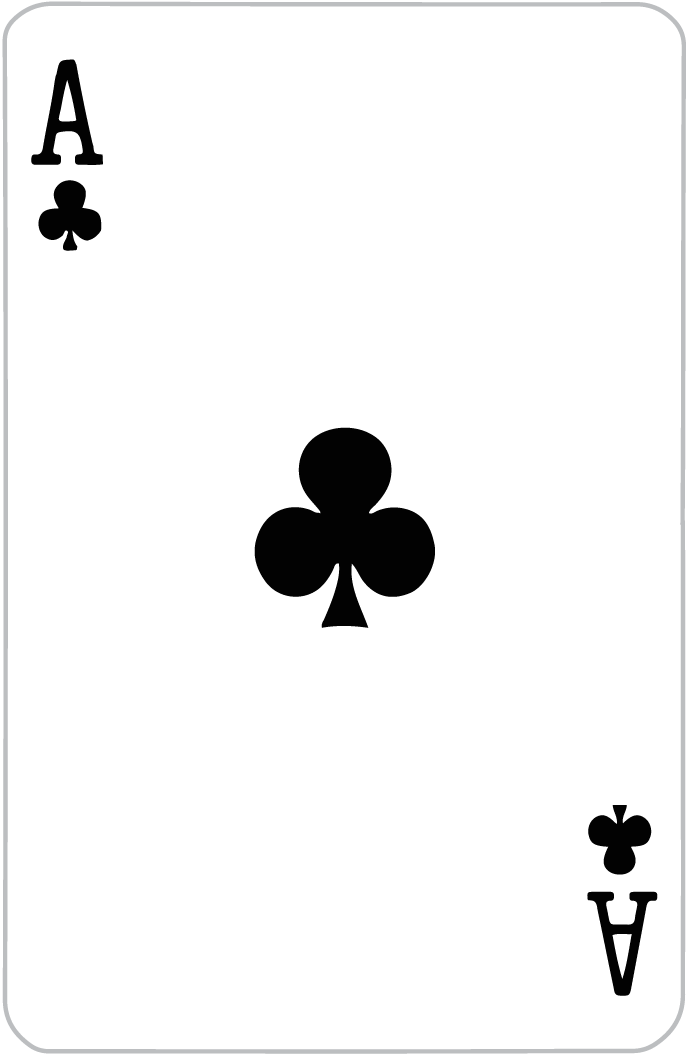


Showdown:

Community Cards:


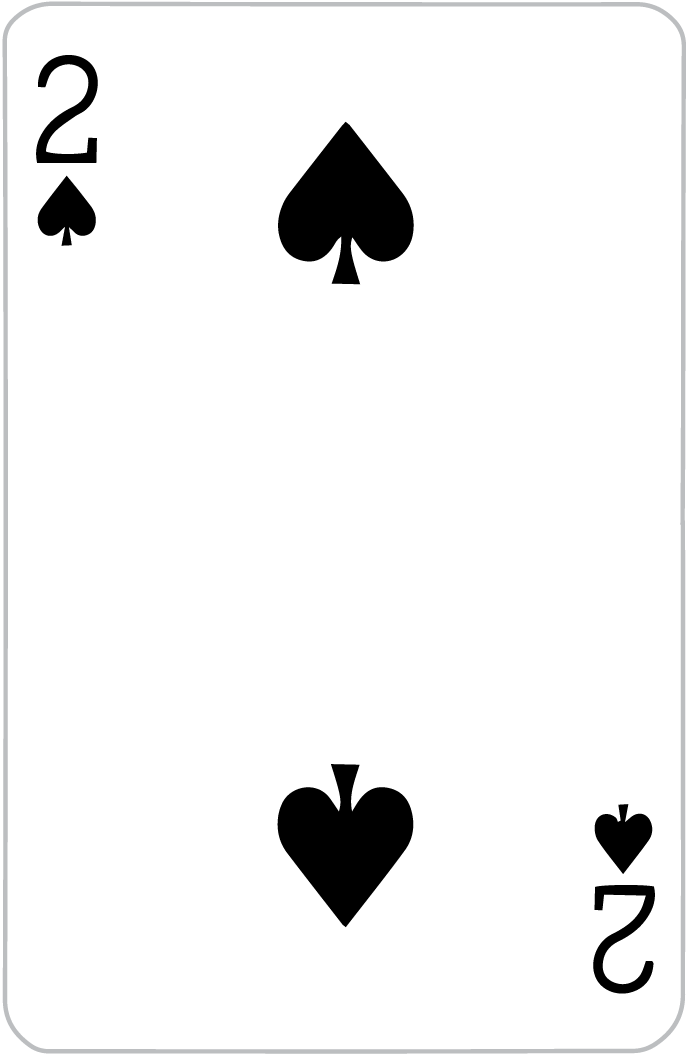

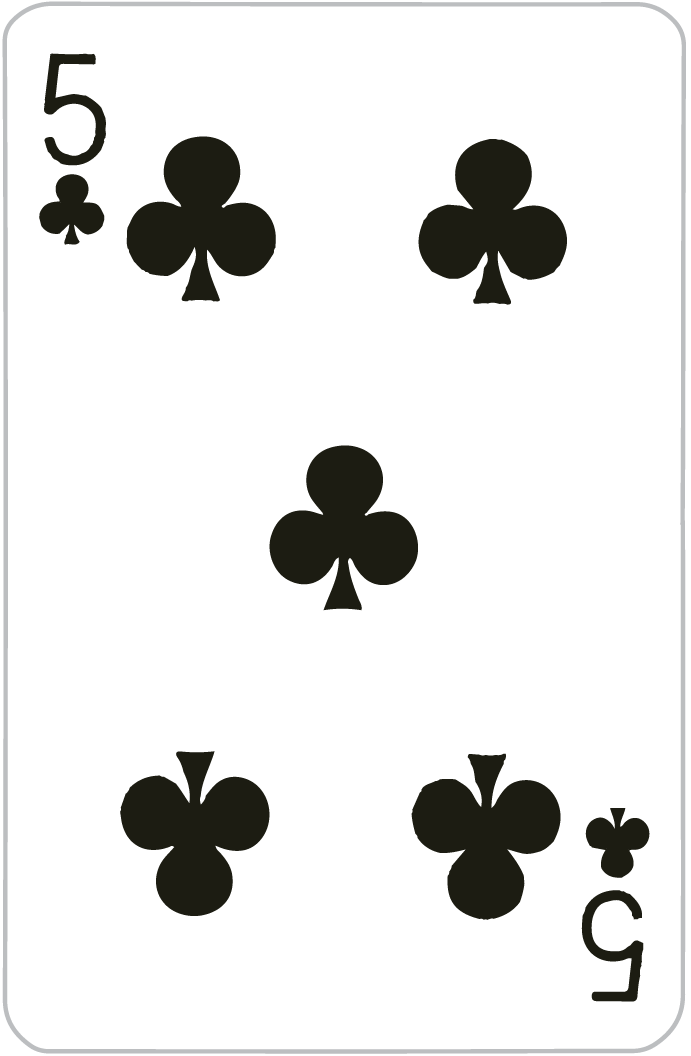

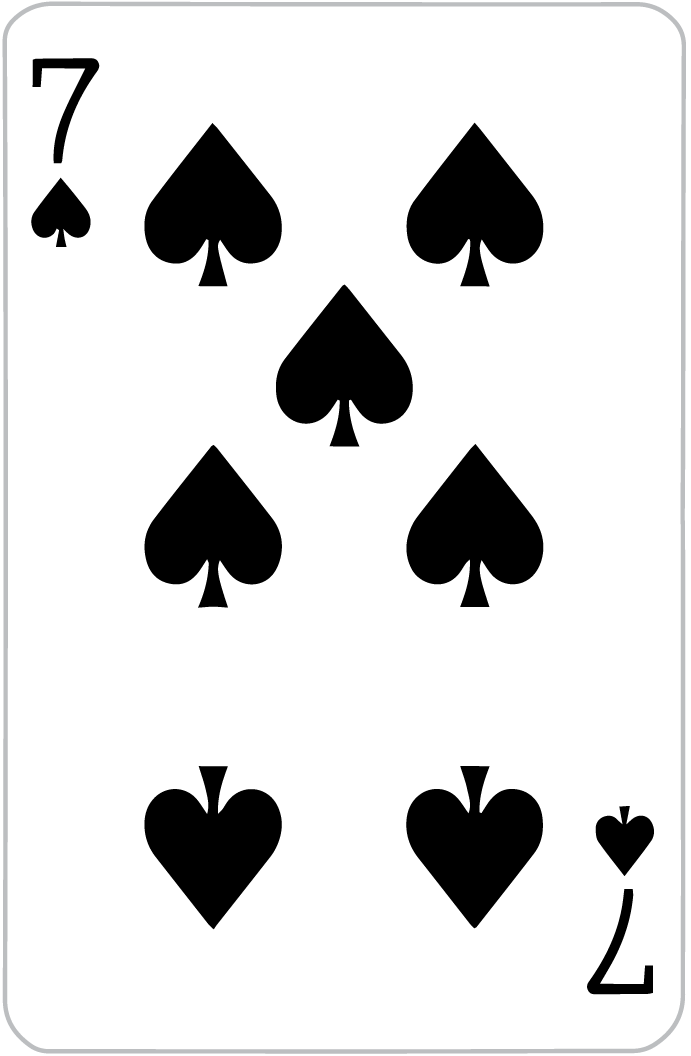

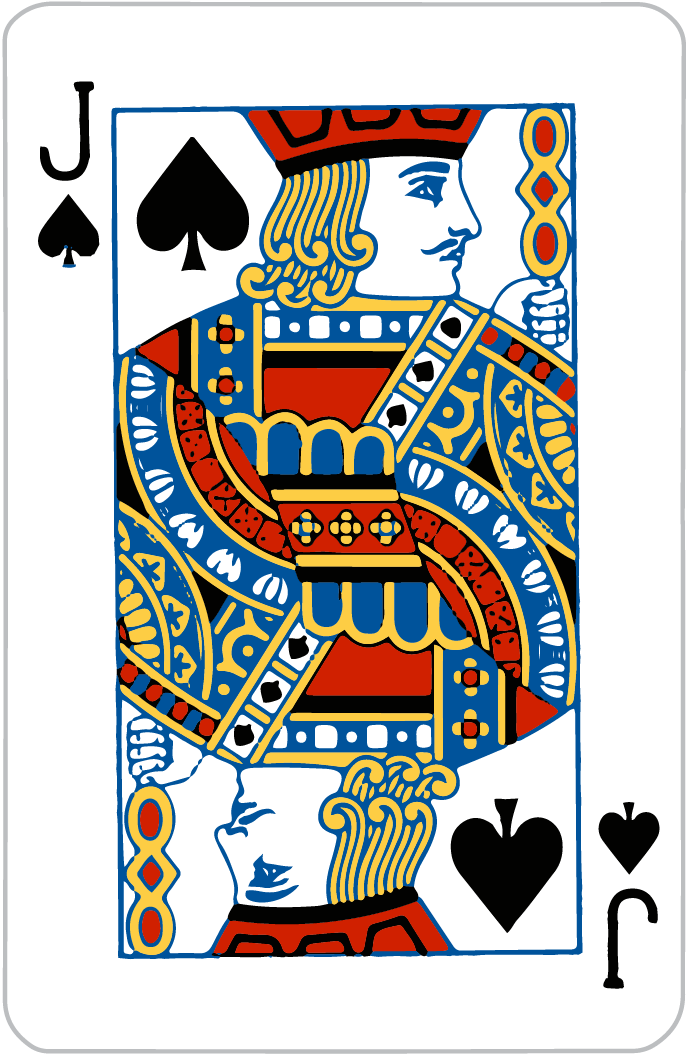

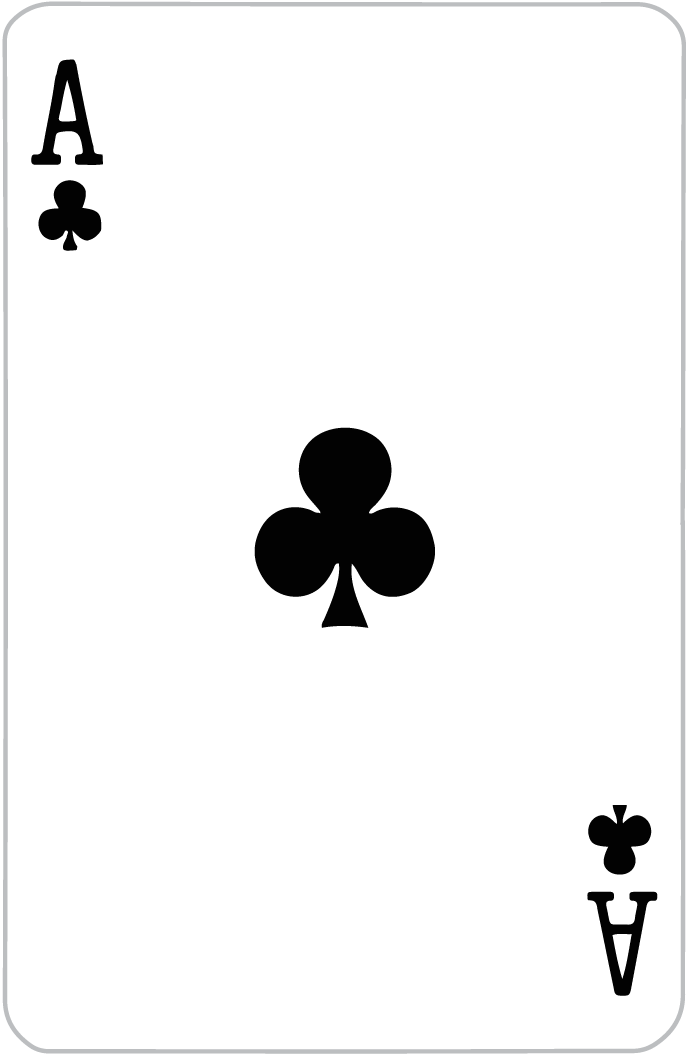


Player 1's hand:


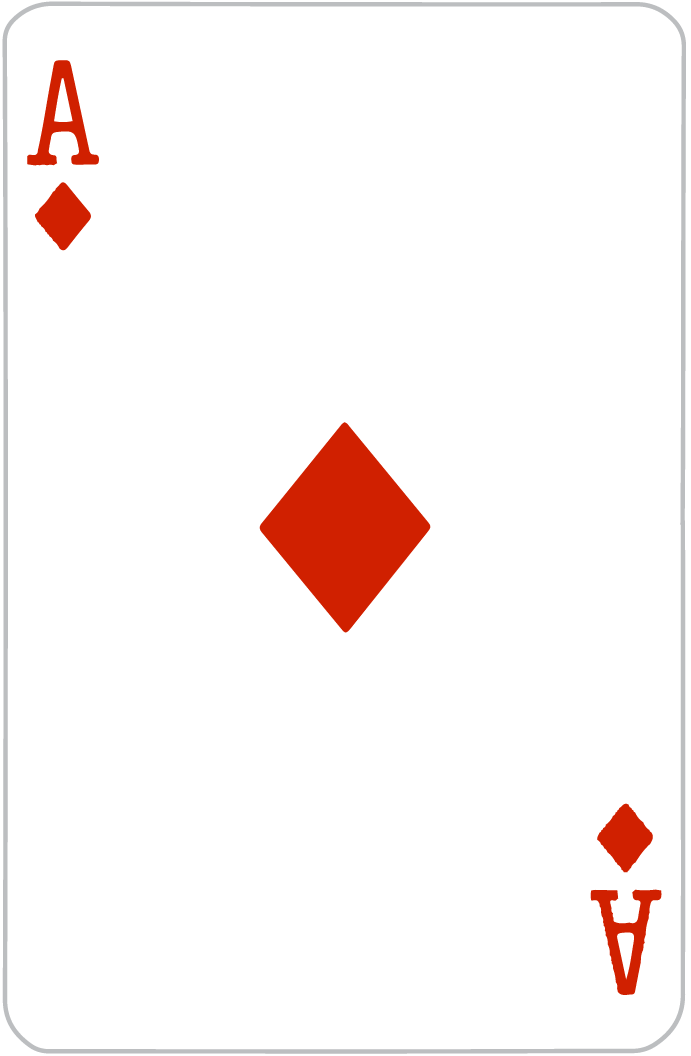

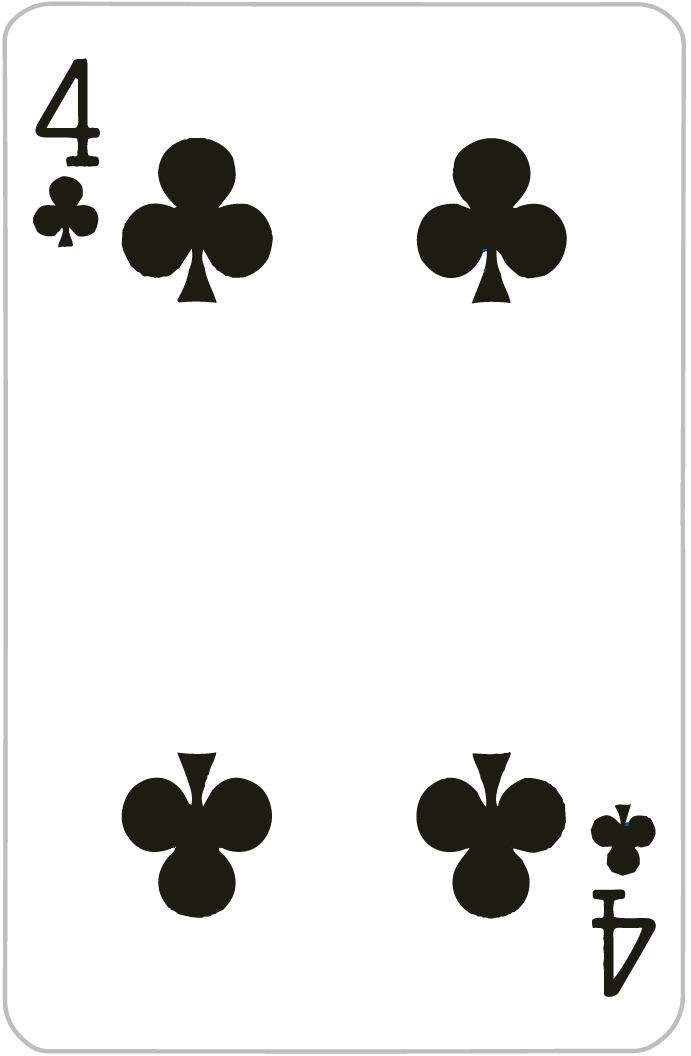


AI Bot's hand:


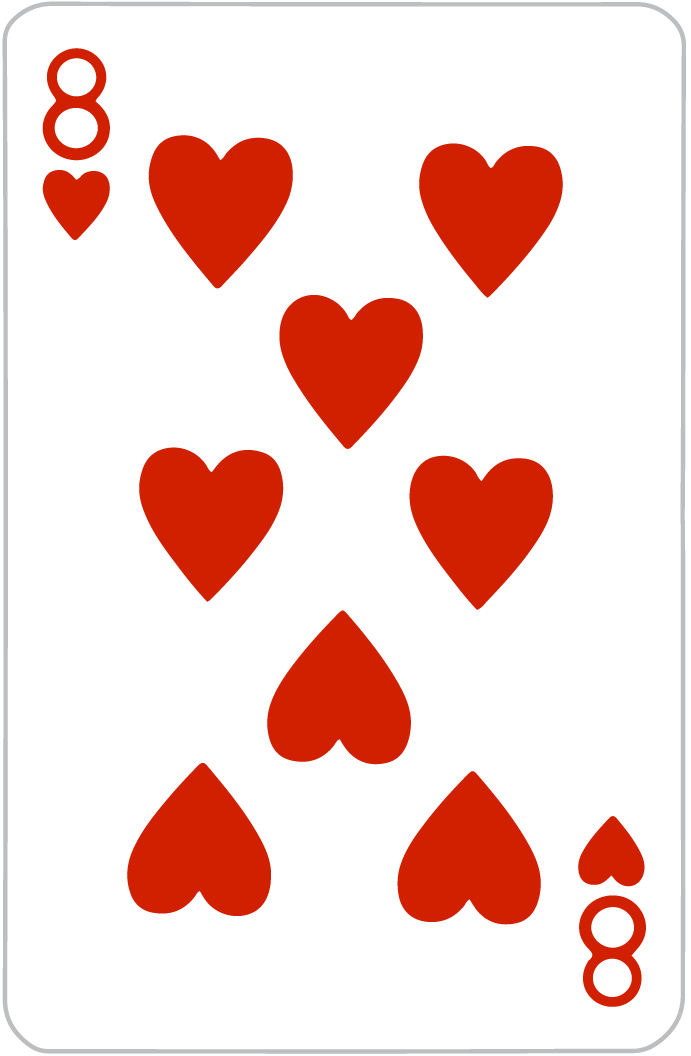

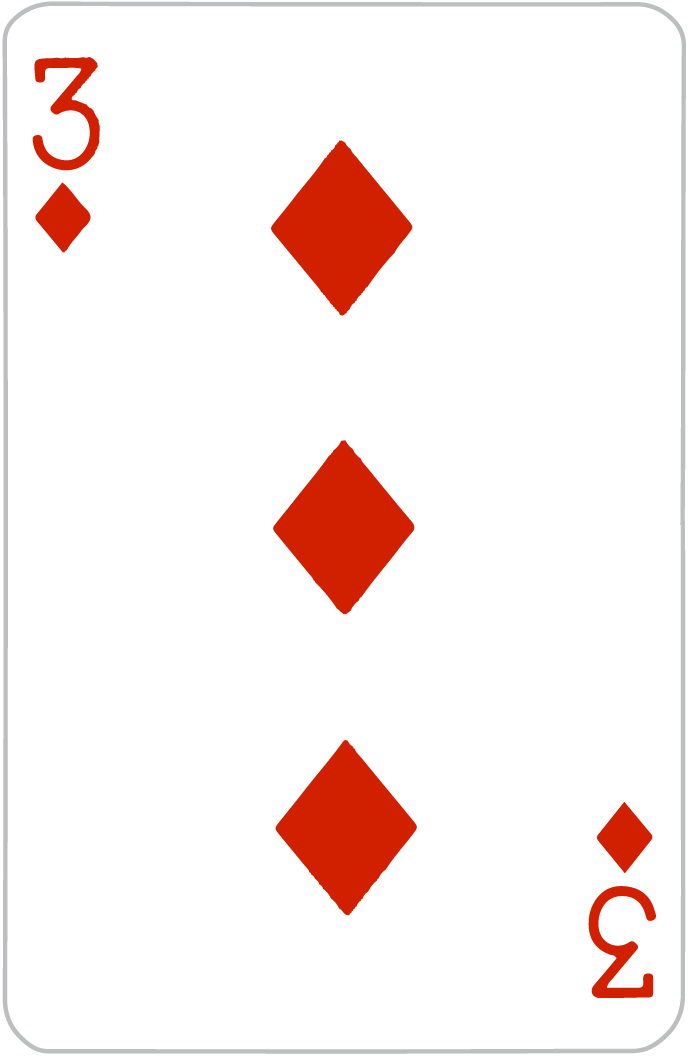


Winner: Player 1
with  15
and get pot = 2000
player:  Player 1 , chips left:  2000
player:  AI Bot , chips left:  0


In [37]:
human_player = Player("Player 1")
ai_bot = AIPlayer("AI Bot")
players = [human_player, ai_bot]
players_with_chips = players
continue_input = ''

while len(players_with_chips) > 1:
    if continue_input == 'N':
      break
    # Check if there's still more than one player with chips
    if len(players_with_chips) > 1:
        print("=======================================\n=======================================")
        print("NEW GAME")
        game = PokerGame(players_with_chips)
        game.play_round()
        for p in players:
          print("player: ", p.name, ", chips left: ", p.chips)
          p.hand = []
          p.hasFold = 0
          p.has_all_in = 0

          players_with_chips = [p for p in players if p.chips > 0]

          # Check if there's still more than one player with chips
          if len(players_with_chips) > 1:
            while(True):
              continue_input = input("there are players available to play, do you want to play more? (Y/N)").upper()
              if continue_input == 'Y':
                pass
              elif continue_input == 'N':
                break
              else:
                print("Invalid action. Please enter 'Y' to play again or 'N' to leave program.\n")

    else:
      break